In [1]:
from __future__ import print_function
# Specify where PyCaffe is
caffe_path = '../../caffe_gt/python'

# Import Numpy and Caffe plus a few other utilities
import sys, os, math, random, time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
sys.path.append(caffe_path)
import caffe
from caffe import layers as L
from caffe import params as P
from caffe import to_proto

../../caffe_gt/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for caffe::LayerParameter already registered; second conversion method ignored.
  from ._caffe import \
../../caffe_gt/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for caffe::SolverParameter already registered; second conversion method ignored.
  from ._caffe import \
../../caffe_gt/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for std::vector<int, std::allocator<int> > already registered; second conversion method ignored.
  from ._caffe import \


In [8]:
# Define the training and testing data
values_celsius = np.array([(float)(c) for c in range(-273,1000)])
# We know that farenheit = celsius * 1.8 + 32.0
values_farenheit = np.array([c*1.8+32.0 for c in values_celsius])

# Split data into training (90%) and testing (10%)
indices = np.random.permutation(values_celsius.shape[0])
training_idx, test_idx = indices[:(int)(90*values_celsius.shape[0]/100)], indices[(int)(90*values_celsius.shape[0]/100):]

values_celsius_train = values_celsius[training_idx]
values_farenheit_train = values_farenheit[training_idx]
values_celsius_test = values_celsius[test_idx]
values_farenheit_test = values_farenheit[test_idx]

In [9]:
# Create a simple network with just one neuron for this task.
# It can learn a linear function y = a*x + b
net = caffe.NetSpec()
net.celsius = L.Input(input_param=dict(shape=dict(dim=[1,1,1,1])), ntop=1)
net.farenheit = L.Input(input_param=dict(shape=dict(dim=[1,1,1,1])), ntop=1)
net.neuron = L.InnerProduct(net.celsius,inner_product_param = dict(
                                                    num_output = 1,
                                                    weight_filler = dict(type='constant'),
                                                    bias_filler = dict(type='constant')))
net.euclidean = L.EuclideanLoss(net.neuron,net.farenheit)
protonet = net.to_proto()
protonet.name = 'net'
with open(protonet.name + '.prototxt', 'w') as f:
    print(protonet, file=f)

In [10]:
# Switch Caffe to GPU Mode
caffe.set_mode_gpu()
# Count available GPUs
print(caffe.enumerate_devices(True))
# Select the first GPU
caffe.set_device(0)

5


In [11]:
# Create a solver with a few typical parameters
# The solver will perform SGD on our data
solver_config = caffe.SolverParameter()
solver_config.train_net = 'net.prototxt'
solver_config.base_lr = 1.0
solver_config.momentum = 0.99
solver_config.weight_decay = 0.00005
solver_config.lr_policy = 'inv'
solver_config.gamma = 0.01
solver_config.power = 0.75
solver_config.max_iter = 2000
solver_config.snapshot = 500
solver_config.snapshot_prefix = 'net'
solver_config.type = 'Adam'
solver_config.display = 1

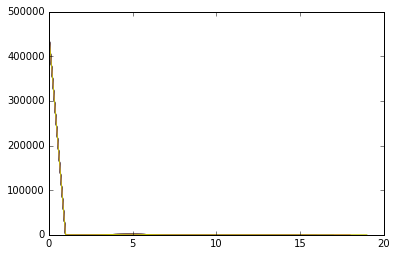

In [12]:
# Do the training
losses = []
solver = caffe.get_solver(solver_config)
for i in range(0,solver_config.max_iter):
    # Pick a random sample for training
    k = random.randint(0,len(values_celsius_train)-1)
    # Load the sample into the network
    solver.net.blobs['celsius'].data[0] = values_celsius_train[k]
    solver.net.blobs['farenheit'].data[0] = values_farenheit_train[k]
    # Train one step
    loss = solver.step(1)
    # Display the learning progress every 20 steps
    if (i % 100 == 0):
        losses.append(loss)
        plt.plot(losses)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)

In [14]:
# Test how accurate the neuron has learned it's task
error = []
testnet = caffe.Net(str('net.prototxt'), 'net_iter_2000.caffemodel', caffe.TEST)
for c,f in zip(values_celsius_test,values_farenheit_test):
    testnet.blobs['celsius'].data[0] = c
    testnet.forward()
    predicted_f = testnet.blobs['neuron'].data[0,0]
    print('Cesius: '+str(c)+'°C, predicted: '+str(predicted_f)+' °F, actual: '+str(f)+' °F')
    error.append(f-predicted_f)
print('Average error: '+str(np.array(error).mean())+' °F')

Cesius: 651.0°C, predicted: 1203.02 °F, actual: 1203.8 °F
Cesius: -141.0°C, predicted: -225.01 °F, actual: -221.8 °F
Cesius: 71.0°C, predicted: 157.241 °F, actual: 159.8 °F
Cesius: 411.0°C, predicted: 770.284 °F, actual: 771.8 °F
Cesius: 790.0°C, predicted: 1453.65 °F, actual: 1454.0 °F
Cesius: 979.0°C, predicted: 1794.43 °F, actual: 1794.2 °F
Cesius: 361.0°C, predicted: 680.131 °F, actual: 681.8 °F
Cesius: -32.0°C, predicted: -28.4754 °F, actual: -25.6 °F
Cesius: 469.0°C, predicted: 874.862 °F, actual: 876.2 °F
Cesius: -143.0°C, predicted: -228.616 °F, actual: -225.4 °F
Cesius: 286.0°C, predicted: 544.901 °F, actual: 546.8 °F
Cesius: 776.0°C, predicted: 1428.4 °F, actual: 1428.8 °F
Cesius: 938.0°C, predicted: 1720.5 °F, actual: 1720.4 °F
Cesius: 47.0°C, predicted: 113.967 °F, actual: 116.6 °F
Cesius: -60.0°C, predicted: -78.9613 °F, actual: -76.0 °F
Cesius: 112.0°C, predicted: 231.167 °F, actual: 233.6 °F
Cesius: -28.0°C, predicted: -21.2631 °F, actual: -18.4 °F
Cesius: 343.0°C, predi